In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

## for bert language model
import transformers

In [2]:
''' The following shows the result of training various non-nerual network models on an augemnted version of the 
Kannada set with negative lebel equalling the positive lebel. models are trained on an tf-idf vectorizer
with dimensionality reduction.'''

' The following shows the result of training various non-nerual network models on an augemnted version of the \nKannada set with negative lebel equalling the positive lebel. models are trained on an tf-idf vectorizer\nwith dimensionality reduction.'

In [3]:
# import data 
kan_train = pd.read_table("../../datasets/task_a/kan_train_negative_augmented.tsv")
kan_dev = pd.read_table("../../datasets/task_a/kan_sentiment_dev.tsv")

In [4]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [5]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


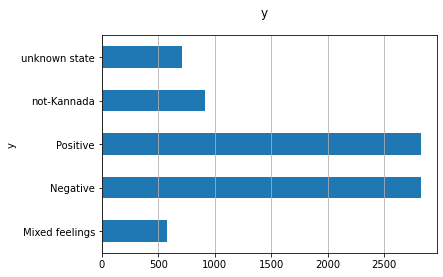

In [6]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
kan_train

,text,y
0,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,Negative
1,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Positive
2,Super sar song,not-Kannada
3,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...,Negative
4,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,Positive
...,...,...
7842,ಇಡೈಲಾ ಕೆಜಿಎಫ್ ಬಿಜಿಎಂ ಕೆಡತು ಎನಕು ಮಧುಮಥಾನ 🤔🤔🤔🤔🤯,Negative
7843,ಜಯಲಲಿತಾ ಮೇಡಂ ಅವರಿಗೆ ಅಮೋಘ ನಿಗ್ರಹ...,Negative
7844,ದಯವಿಟ್ಟು ಎಲ್ಲದರ ಚಿತ್ರ ತೆಗೆಯಿರಿ ಸರ್.,Negative
7845,ಭಾರತದ ಅತಿ ದೊಡ್ಡ ಹೆದ್ದಾರಿ! ಭಾರತದ ದೊಡ್ಡ ತಾರೆಗಳು!...,Negative


In [8]:
# Now we can define our training data and our dev data as well as targets
train = kan_train
test = kan_dev

y_train = kan_train['y'].values
y_test = kan_dev['y'].values


In [9]:
# for ensemble: 
results = pd.DataFrame(kan_dev['y'])

## Using Tf-Idf vectorizer

In [10]:
## Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [11]:
# now run thse vectorizers on the train data
corpus = train["text"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [12]:
X_train

<7847x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 56107 stored elements in Compressed Sparse Row format>

Text(0.5, 1.0, 'Sparse Matrix Sample')

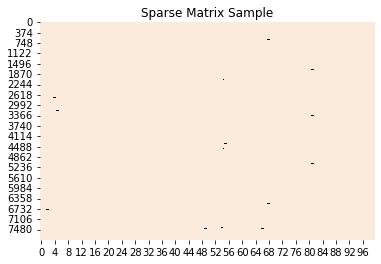

In [13]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

## reducing the vectorizers dimensionality

In [14]:
# reduce dimensionality through feature selection

y = y_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [15]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# Mixed feelings:
  . selected features: 410
  . top features: game,yava game,game name,yavadu,game yavdu,ಅದ ಪದ,bro game,bigg boss,32,game yavadu
 
# Negative:
  . selected features: 392
  . top features: super,ಲರ,song,bro,ಅಜ,ಇಲ,ಜಯ,ಆಹ,ಎಲ,ದರ
 
# Positive:
  . selected features: 189
  . top features: ದನ ಗಡ,ಗಡ ಇದ,ಪರ,guru,ಚರ,ದನ,ಅವತ,anna,ಇದ ಚರ,ಚರ ಅವತ
 
# not-Kannada:
  . selected features: 475
  . top features: bro,super,super bro,super song,song,anjali devi,devi,anjali,super super,nice
 
# unknown state:
  . selected features: 447
  . top features: yes,gta,gta bro,paramvah,paramvah music,lokanath,like,join,yes bro,abhi
 


## re-fitting the vectorizer on the new vocabulary gained through feature reduction

In [16]:
# we can now refit the vecotrizer on the corpus by giving this new set of words as input.
# producing a smaller feature matrix and a shorter vocabulary.
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


In [17]:
X_train.shape

(7847, 1700)

Text(0.5, 1.0, 'Sparse Matrix Sample')

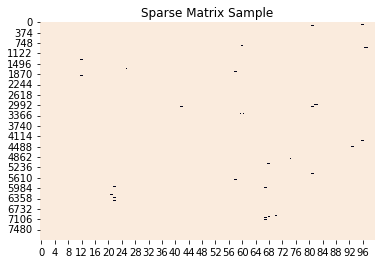

In [18]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

# Training a cat boost classifier

In [19]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(
    iterations=1500, 
    learning_rate=1.5, 
    #loss_function='CrossEntropy'
)


In [20]:
## pipeline
model_cat = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", cat)])
## train classifier
model_cat["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model_cat.predict(X_test)
results['cat_boost_neg_tfidf'] = predicted
predicted_prob = model_cat.predict_proba(X_test)

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 1.3978169	total: 105ms	remaining: 2m 37s
1:	learn: 1.3867790	total: 147ms	remaining: 1m 50s
2:	learn: 1.3264683	total: 190ms	remaining: 1m 35s
3:	learn: 1.3139599	total: 234ms	remaining: 1m 27s
4:	learn: 1.2925152	total: 276ms	remaining: 1m 22s
5:	learn: 1.3084846	total: 319ms	remaining: 1m 19s
6:	learn: 1.3490215	total: 361ms	remaining: 1m 17s
7:	learn: 1.9499848	total: 404ms	remaining: 1m 15s
8:	learn: 6.0066015	total: 449ms	remaining: 1m 14s
9:	learn: 4.1179646	total: 492ms	remaining: 1m 13s
10:	learn: 2.9060044	total: 536ms	remaining: 1m 12s
11:	learn: 3.6558488	total: 579ms	remaining: 1m 11s
12:	learn: 2.8840208	total: 621ms	remaining: 1m 11s
13:	learn: 2.5427942	total: 665ms	remaining: 1m 10s
14:	learn: 2.1043396	total: 707ms	remaining: 1m 10s
15:	learn: 2.0901403	total: 751ms	remaining: 1m 9s
16:	learn: 2.0304655	total: 793ms	remaining: 1m 9s
17:	learn: 1.9864251	total: 835ms	remaining: 1m 8s
18:	learn: 1.9408969	total: 878ms	remaining: 1m 8s
19:	learn: 1.9079108	total

165:	learn: 1.2544710	total: 7.12s	remaining: 57.2s
166:	learn: 1.2536656	total: 7.16s	remaining: 57.2s
167:	learn: 1.2505181	total: 7.21s	remaining: 57.1s
168:	learn: 1.2481303	total: 7.25s	remaining: 57.1s
169:	learn: 1.2442456	total: 7.29s	remaining: 57s
170:	learn: 1.2430318	total: 7.33s	remaining: 57s
171:	learn: 1.2416289	total: 7.38s	remaining: 56.9s
172:	learn: 1.2405509	total: 7.42s	remaining: 56.9s
173:	learn: 1.2396320	total: 7.46s	remaining: 56.9s
174:	learn: 1.2388408	total: 7.5s	remaining: 56.8s
175:	learn: 1.2377373	total: 7.54s	remaining: 56.8s
176:	learn: 1.2363788	total: 7.59s	remaining: 56.7s
177:	learn: 1.2354400	total: 7.63s	remaining: 56.7s
178:	learn: 1.2339295	total: 7.67s	remaining: 56.6s
179:	learn: 1.2326519	total: 7.71s	remaining: 56.6s
180:	learn: 1.2318049	total: 7.76s	remaining: 56.5s
181:	learn: 1.2311560	total: 7.8s	remaining: 56.5s
182:	learn: 1.2288081	total: 7.84s	remaining: 56.4s
183:	learn: 1.2279562	total: 7.88s	remaining: 56.4s
184:	learn: 1.2274

325:	learn: 1.0839925	total: 13.9s	remaining: 50.1s
326:	learn: 1.0834220	total: 14s	remaining: 50s
327:	learn: 1.0827696	total: 14s	remaining: 50s
328:	learn: 1.0823603	total: 14s	remaining: 50s
329:	learn: 1.0815584	total: 14.1s	remaining: 49.9s
330:	learn: 1.0810488	total: 14.1s	remaining: 49.9s
331:	learn: 1.0806649	total: 14.2s	remaining: 49.8s
332:	learn: 1.0797809	total: 14.2s	remaining: 49.8s
333:	learn: 1.0790932	total: 14.2s	remaining: 49.7s
334:	learn: 1.0784849	total: 14.3s	remaining: 49.7s
335:	learn: 1.0777787	total: 14.3s	remaining: 49.6s
336:	learn: 1.0773427	total: 14.4s	remaining: 49.6s
337:	learn: 1.0765005	total: 14.4s	remaining: 49.6s
338:	learn: 1.0744202	total: 14.5s	remaining: 49.5s
339:	learn: 1.0700715	total: 14.5s	remaining: 49.5s
340:	learn: 1.0691658	total: 14.5s	remaining: 49.4s
341:	learn: 1.0688085	total: 14.6s	remaining: 49.4s
342:	learn: 1.0680845	total: 14.6s	remaining: 49.3s
343:	learn: 1.0676879	total: 14.7s	remaining: 49.3s
344:	learn: 1.0669181	to

485:	learn: 0.9552790	total: 20.7s	remaining: 43.2s
486:	learn: 0.9542198	total: 20.8s	remaining: 43.2s
487:	learn: 0.9539425	total: 20.8s	remaining: 43.1s
488:	learn: 0.9534789	total: 20.9s	remaining: 43.1s
489:	learn: 0.9531507	total: 20.9s	remaining: 43.1s
490:	learn: 0.9527666	total: 20.9s	remaining: 43s
491:	learn: 0.9512134	total: 21s	remaining: 43s
492:	learn: 0.9508473	total: 21s	remaining: 43s
493:	learn: 0.9501507	total: 21.1s	remaining: 42.9s
494:	learn: 0.9491868	total: 21.1s	remaining: 42.9s
495:	learn: 0.9489722	total: 21.2s	remaining: 42.8s
496:	learn: 0.9485827	total: 21.2s	remaining: 42.8s
497:	learn: 0.9476564	total: 21.3s	remaining: 42.8s
498:	learn: 0.9473153	total: 21.3s	remaining: 42.7s
499:	learn: 0.9470284	total: 21.3s	remaining: 42.7s
500:	learn: 0.9466244	total: 21.4s	remaining: 42.6s
501:	learn: 0.9460948	total: 21.4s	remaining: 42.6s
502:	learn: 0.9455548	total: 21.5s	remaining: 42.6s
503:	learn: 0.9452863	total: 21.5s	remaining: 42.5s
504:	learn: 0.9449521	

644:	learn: 0.8543475	total: 27.6s	remaining: 36.6s
645:	learn: 0.8540498	total: 27.6s	remaining: 36.5s
646:	learn: 0.8536632	total: 27.7s	remaining: 36.5s
647:	learn: 0.8533989	total: 27.7s	remaining: 36.4s
648:	learn: 0.8529339	total: 27.7s	remaining: 36.4s
649:	learn: 0.8519594	total: 27.8s	remaining: 36.3s
650:	learn: 0.8513076	total: 27.8s	remaining: 36.3s
651:	learn: 0.8509758	total: 27.9s	remaining: 36.3s
652:	learn: 0.8497036	total: 27.9s	remaining: 36.2s
653:	learn: 0.8495054	total: 28s	remaining: 36.2s
654:	learn: 0.8484489	total: 28s	remaining: 36.1s
655:	learn: 0.8482637	total: 28s	remaining: 36.1s
656:	learn: 0.8478863	total: 28.1s	remaining: 36s
657:	learn: 0.8475809	total: 28.1s	remaining: 36s
658:	learn: 0.8471696	total: 28.2s	remaining: 35.9s
659:	learn: 0.8469162	total: 28.2s	remaining: 35.9s
660:	learn: 0.8460849	total: 28.3s	remaining: 35.9s
661:	learn: 0.8458138	total: 28.3s	remaining: 35.8s
662:	learn: 0.8455062	total: 28.3s	remaining: 35.8s
663:	learn: 0.8452445	

804:	learn: 0.7738947	total: 34.4s	remaining: 29.7s
805:	learn: 0.7733415	total: 34.4s	remaining: 29.6s
806:	learn: 0.7730120	total: 34.5s	remaining: 29.6s
807:	learn: 0.7725995	total: 34.5s	remaining: 29.5s
808:	learn: 0.7722450	total: 34.5s	remaining: 29.5s
809:	learn: 0.7715465	total: 34.6s	remaining: 29.5s
810:	learn: 0.7712767	total: 34.6s	remaining: 29.4s
811:	learn: 0.7705856	total: 34.7s	remaining: 29.4s
812:	learn: 0.7702375	total: 34.7s	remaining: 29.3s
813:	learn: 0.7694817	total: 34.8s	remaining: 29.3s
814:	learn: 0.7691375	total: 34.8s	remaining: 29.2s
815:	learn: 0.7688201	total: 34.8s	remaining: 29.2s
816:	learn: 0.7685117	total: 34.9s	remaining: 29.2s
817:	learn: 0.7680488	total: 34.9s	remaining: 29.1s
818:	learn: 0.7673560	total: 35s	remaining: 29.1s
819:	learn: 0.7671109	total: 35s	remaining: 29s
820:	learn: 0.7669010	total: 35s	remaining: 29s
821:	learn: 0.7664635	total: 35.1s	remaining: 28.9s
822:	learn: 0.7660004	total: 35.1s	remaining: 28.9s
823:	learn: 0.7658009	

964:	learn: 0.7124965	total: 41.2s	remaining: 22.8s
965:	learn: 0.7121417	total: 41.2s	remaining: 22.8s
966:	learn: 0.7112969	total: 41.3s	remaining: 22.7s
967:	learn: 0.7102708	total: 41.3s	remaining: 22.7s
968:	learn: 0.7097855	total: 41.4s	remaining: 22.7s
969:	learn: 0.7094748	total: 41.4s	remaining: 22.6s
970:	learn: 0.7091278	total: 41.4s	remaining: 22.6s
971:	learn: 0.7089505	total: 41.5s	remaining: 22.5s
972:	learn: 0.7086609	total: 41.5s	remaining: 22.5s
973:	learn: 0.7084429	total: 41.6s	remaining: 22.4s
974:	learn: 0.7080703	total: 41.6s	remaining: 22.4s
975:	learn: 0.7078856	total: 41.6s	remaining: 22.4s
976:	learn: 0.7076307	total: 41.7s	remaining: 22.3s
977:	learn: 0.7075424	total: 41.7s	remaining: 22.3s
978:	learn: 0.7073648	total: 41.8s	remaining: 22.2s
979:	learn: 0.7072285	total: 41.8s	remaining: 22.2s
980:	learn: 0.7071223	total: 41.9s	remaining: 22.1s
981:	learn: 0.7067175	total: 41.9s	remaining: 22.1s
982:	learn: 0.7065683	total: 41.9s	remaining: 22.1s
983:	learn: 

1124:	learn: 0.6637746	total: 48s	remaining: 16s
1125:	learn: 0.6635034	total: 48s	remaining: 15.9s
1126:	learn: 0.6617184	total: 48.1s	remaining: 15.9s
1127:	learn: 0.6614490	total: 48.1s	remaining: 15.9s
1128:	learn: 0.6611326	total: 48.1s	remaining: 15.8s
1129:	learn: 0.6608956	total: 48.2s	remaining: 15.8s
1130:	learn: 0.6608152	total: 48.2s	remaining: 15.7s
1131:	learn: 0.6607243	total: 48.3s	remaining: 15.7s
1132:	learn: 0.6606050	total: 48.3s	remaining: 15.7s
1133:	learn: 0.6605070	total: 48.4s	remaining: 15.6s
1134:	learn: 0.6600087	total: 48.4s	remaining: 15.6s
1135:	learn: 0.6598605	total: 48.4s	remaining: 15.5s
1136:	learn: 0.6595874	total: 48.5s	remaining: 15.5s
1137:	learn: 0.6595177	total: 48.5s	remaining: 15.4s
1138:	learn: 0.6591689	total: 48.6s	remaining: 15.4s
1139:	learn: 0.6590984	total: 48.6s	remaining: 15.4s
1140:	learn: 0.6589553	total: 48.7s	remaining: 15.3s
1141:	learn: 0.6588928	total: 48.7s	remaining: 15.3s
1142:	learn: 0.6587296	total: 48.7s	remaining: 15.2s

1284:	learn: 0.6210823	total: 54.8s	remaining: 9.17s
1285:	learn: 0.6210263	total: 54.8s	remaining: 9.12s
1286:	learn: 0.6209341	total: 54.9s	remaining: 9.08s
1287:	learn: 0.6208919	total: 54.9s	remaining: 9.04s
1288:	learn: 0.6207172	total: 55s	remaining: 9s
1289:	learn: 0.6205867	total: 55s	remaining: 8.95s
1290:	learn: 0.6204951	total: 55s	remaining: 8.91s
1291:	learn: 0.6201850	total: 55.1s	remaining: 8.87s
1292:	learn: 0.6200420	total: 55.1s	remaining: 8.82s
1293:	learn: 0.6199588	total: 55.2s	remaining: 8.78s
1294:	learn: 0.6198821	total: 55.2s	remaining: 8.74s
1295:	learn: 0.6198219	total: 55.3s	remaining: 8.7s
1296:	learn: 0.6196953	total: 55.3s	remaining: 8.65s
1297:	learn: 0.6193239	total: 55.3s	remaining: 8.61s
1298:	learn: 0.6191466	total: 55.4s	remaining: 8.57s
1299:	learn: 0.6190766	total: 55.4s	remaining: 8.53s
1300:	learn: 0.6189957	total: 55.5s	remaining: 8.48s
1301:	learn: 0.6189088	total: 55.5s	remaining: 8.44s
1302:	learn: 0.6188360	total: 55.6s	remaining: 8.4s
1303

1444:	learn: 0.5898292	total: 1m 1s	remaining: 2.34s
1445:	learn: 0.5895858	total: 1m 1s	remaining: 2.3s
1446:	learn: 0.5895402	total: 1m 1s	remaining: 2.26s
1447:	learn: 0.5894958	total: 1m 1s	remaining: 2.22s
1448:	learn: 0.5894304	total: 1m 1s	remaining: 2.17s
1449:	learn: 0.5892192	total: 1m 1s	remaining: 2.13s
1450:	learn: 0.5890806	total: 1m 1s	remaining: 2.09s
1451:	learn: 0.5888911	total: 1m 1s	remaining: 2.04s
1452:	learn: 0.5888419	total: 1m 1s	remaining: 2s
1453:	learn: 0.5888180	total: 1m 1s	remaining: 1.96s
1454:	learn: 0.5887915	total: 1m 2s	remaining: 1.92s
1455:	learn: 0.5886938	total: 1m 2s	remaining: 1.88s
1456:	learn: 0.5885342	total: 1m 2s	remaining: 1.83s
1457:	learn: 0.5885144	total: 1m 2s	remaining: 1.79s
1458:	learn: 0.5884786	total: 1m 2s	remaining: 1.75s
1459:	learn: 0.5882258	total: 1m 2s	remaining: 1.7s
1460:	learn: 0.5881397	total: 1m 2s	remaining: 1.66s
1461:	learn: 0.5873060	total: 1m 2s	remaining: 1.62s
1462:	learn: 0.5871874	total: 1m 2s	remaining: 1.58

Accuracy: 0.52
Auc: 0.76
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.31      0.15      0.21        52
      Negative       0.36      0.57      0.44       139
      Positive       0.66      0.62      0.64       321
   not-Kannada       0.61      0.56      0.58       110
 unknown state       0.28      0.17      0.21        69

      accuracy                           0.52       691
     macro avg       0.44      0.42      0.42       691
  weighted avg       0.53      0.52      0.52       691



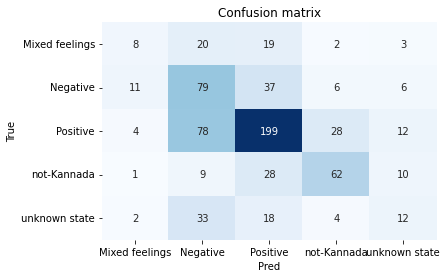

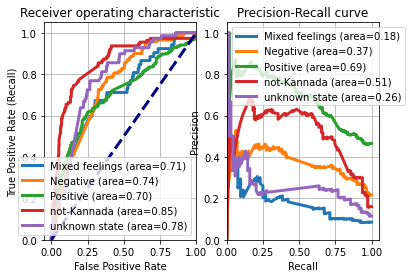

In [21]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=200, n_estimators=15, max_features=1700)

In [23]:
## pipeline
model_forest = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", forest)])
## train classifier
model_forest["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model_forest.predict(X_test)
results['forest_neg_tfidf'] = predicted
predicted_prob = model_forest.predict_proba(X_test)

Accuracy: 0.52
Auc: 0.75
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.28      0.10      0.14        52
      Negative       0.36      0.64      0.46       139
      Positive       0.66      0.63      0.64       321
   not-Kannada       0.55      0.48      0.51       110
 unknown state       0.30      0.12      0.17        69

      accuracy                           0.52       691
     macro avg       0.43      0.39      0.39       691
  weighted avg       0.52      0.52      0.50       691



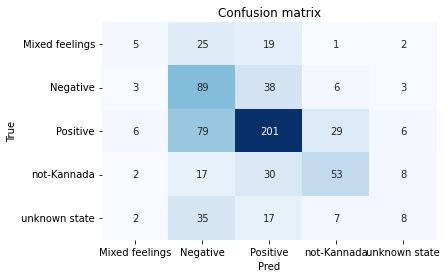

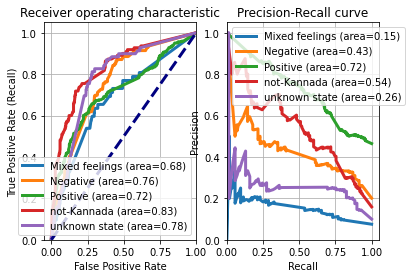

In [24]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [25]:
from sklearn.linear_model import LogisticRegression
log =LogisticRegression(random_state=0, max_iter= 100)

In [26]:
## pipeline
model_log = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", log)])
## train classifier
model_log["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model_log.predict(X_test)
results['log_neg_tfidf'] = predicted
predicted_prob = model_log.predict_proba(X_test)

/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.54
Auc: 0.78
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.40      0.04      0.07        52
      Negative       0.39      0.65      0.49       139
      Positive       0.65      0.67      0.66       321
   not-Kannada       0.53      0.42      0.47       110
 unknown state       0.43      0.23      0.30        69

      accuracy                           0.54       691
     macro avg       0.48      0.40      0.40       691
  weighted avg       0.54      0.54      0.51       691



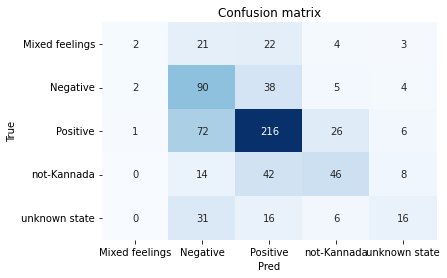

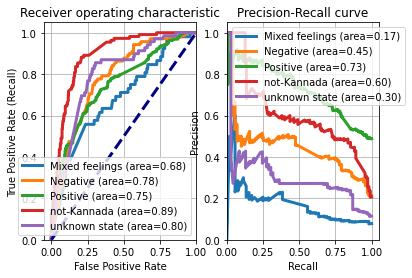

In [27]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [29]:
## pipeline
model_neigh = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", neigh)])
## train classifier
model_neigh["classifier"].fit(X_train, y_train)
## test
X_test = test["text"].values
predicted = model_neigh.predict(X_test)
results['neigh_neg_tfidf'] = predicted
predicted_prob = model_neigh.predict_proba(X_test)

Accuracy: 0.49
Auc: 0.69
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.22      0.15      0.18        52
      Negative       0.35      0.55      0.43       139
      Positive       0.64      0.56      0.60       321
   not-Kannada       0.52      0.55      0.54       110
 unknown state       0.28      0.16      0.20        69

      accuracy                           0.49       691
     macro avg       0.40      0.40      0.39       691
  weighted avg       0.50      0.49      0.48       691



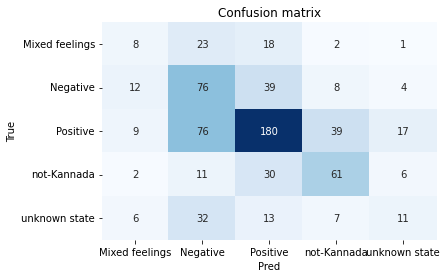

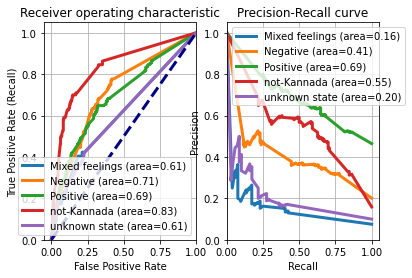

In [30]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Ensemble

In [31]:
results.replace(['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], [0,1,2,3,4], inplace=True)
results['neg_majority_label_tfidf'] = results[results.columns[1:]].mode(axis=1)[0].astype(int)
results.replace([0,1,2,3,4], ['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], inplace=True)
results.to_csv('kan_results_neg_tfidf.tsv', sep="\t", index = False)

                precision    recall  f1-score   support

Mixed feelings       0.35      0.12      0.17        52
      Negative       0.38      0.65      0.48       139
      Positive       0.67      0.66      0.67       321
   not-Kannada       0.63      0.50      0.56       110
 unknown state       0.39      0.19      0.25        69

      accuracy                           0.55       691
     macro avg       0.49      0.42      0.43       691
  weighted avg       0.56      0.55      0.53       691



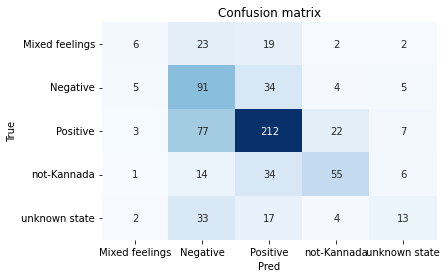

In [32]:
## Plot confusion matrix
print(metrics.classification_report(results['y'], results['neg_majority_label_tfidf'] ))
cm = metrics.confusion_matrix(results['y'], results['neg_majority_label_tfidf'] )
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()